In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

from ipywidgets import widgets
from IPython.display import clear_output, display

def standard_units(any_numbers):
    "Convert a sequence of numbers to standard units."
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

def standardize(df):
    """Return a DataFrame in which all columns of df are converted to standard units."""
    df_su = bpd.DataFrame()
    for column in df.columns:
        df_su = df_su.assign(**{column + ' (su)': standard_units(df.get(column))})
    return df_su

# All of the following code is for visualization.
def plot_regression_line(df, x, y, margin=0.02, alpha=1):
    '''Computes the slope and intercept of the regression line between columns x and y in df (in original units) and plots it.'''
    m = slope(df, x, y)
    b = intercept(df, x, y)
    
    df.plot(kind='scatter', x=x, y=y, figsize=(10, 5), label='original data', alpha=alpha)
    left = df.get(x).min()*(1 - margin)
    right = df.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='purple', label='regression line')
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.legend();
    
# Just for visual purposes
def format_equation(m, b):
    if b > 0:
        return r'$y = %.2fx + %.2f$' % (m, b)
    elif b == 0:
        return r'$y = %.2fx' % m
    else:
        return r'$y = %.2fx %.2f$' % (m, b)
    
# Don't worry about how this function works.
def plot_errors(df, m, b, x_col='x', y_col='y'):
    x = df.get(x_col)
    y = m*x + b
    df.plot(kind='scatter', x=x_col, y=y_col, figsize=(10, 5), label='original data')
    plt.plot(x, y, color='purple', label='regression line')
    for k in np.arange(df.shape[0]):
        xk = df.get(x_col).iloc[k]
        yk = np.asarray(y)[k]
        if k == df.shape[0] - 1:
            plt.plot([xk, xk], [yk, df.get(y_col).iloc[k]], '--', c='r', linewidth=2, label='errors')
        else:
            plt.plot([xk, xk], [yk, df.get(y_col).iloc[k]], '--', c='r', linewidth=2)
    
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.xlim(50, 90)
    plt.ylim(40, 100)
    plt.legend();
    
def update_plot(w):
    m = slope_widget.value
    b = galton.get('childHeight').mean() - m * galton.get('midparentHeight').mean()
    with out:
        out.clear_output(wait=True)
        plot_errors(galton, m, b, x_col='childHeight', y_col='midparentHeight')
        plt.show()

# Lecture 26 – Residuals and Inference

## DSC 10, Summer 2022

### Announcements

- Lab 8 is due **tomorrow at 11:59pm**.
- The Final Project is due **Wednesday at 11:59pm**
    - To use a slip day, you and your partner both need to have one remaining.
- The Final Exam is on **Saturday, 9/3 from 11:30am-2:30pm**.

### Agenda

- Residuals.
- Inference for regression.

## Residuals

### Quality of fit

- The regression line describes the "best linear fit" for a given dataset.
- The formulas for the slope and intercept work no matter what the shape of the data is.
- But the line is only meaningful if the relationship between $x$ and $y$ is roughly linear.

### Residuals

- The errors of a regression line's predictions are called **residuals**.
- There is one residual corresponding to each data point $(x, y)$ in the dataset.

$$\text{residual} = \text{actual } y - \text{predicted } y \text{ by regression line}$$

### Calculating residuals

In [2]:
def correlation(df, x, y):
    '''Computes the correlation between column x and column y of df.'''
    return (standard_units(df.get(x)) * standard_units(df.get(y))).mean()

def slope(df, x, y):
    '''Returns the slope of the regression line between columns x and y in df (in original units).'''
    r = correlation(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    '''Returns the intercept of the regression line between columns x and y in df (in original units).'''
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()

In [3]:
def fit(df, x, y):
    m = slope(df, x, y)
    b = intercept(df, x, y)
    return m * df.get(x) + b

def residual(df, x, y):
    return df.get(y) - fit(df, x, y)

### Predicting child height 👪 📏

- Is the association between `'midparentHeight'` and `'childHeight'` linear?
    - If there is a linear association, is it strong?
        - We can answer this using the correlation coefficient.
        - Close to 0 = weak, close to -1/+1 = strong.
    - Is "linear" the best description of the association between `'midparentHeight'` and `'childHeight'`?
        - We'll use residuals to answer this question.

In [4]:
galton = bpd.read_csv('data/galton.csv')

heights = bpd.DataFrame().assign(
    MidParent=galton.get('midparentHeight'),
    Child=galton.get('childHeight')
)

fitted = heights.assign(
    fit=fit(heights, 'MidParent', 'Child'),
    residuals=residual(heights, 'MidParent', 'Child'),
)

Correlation: 0.320949896063959


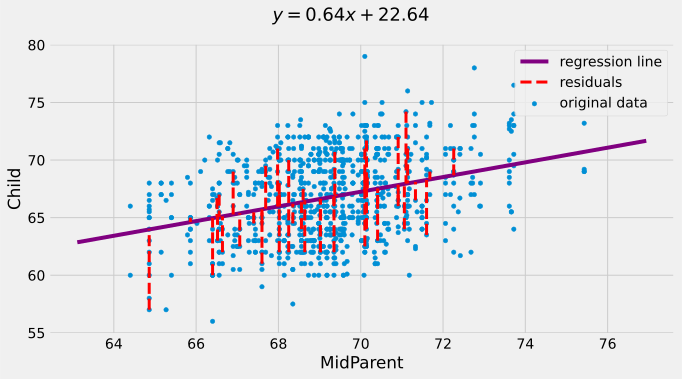

In [5]:
plot_regression_line(fitted, 'MidParent', 'Child')

idx = np.random.randint(0, fitted.shape[0], size=50)
for i, k in enumerate(idx):
    x = fitted.get('MidParent').iloc[k]
    y = fitted.get('Child').iloc[k]
    p = fitted.get('fit').iloc[k]
    plt.plot([x,x], [y,p], '--', linewidth=3, color='red', label='residuals' if i==0 else None)
plt.legend();
print('Correlation:', correlation(galton, 'midparentHeight', 'childHeight'))

### The residual plot

- The residual plot is the scatter plot with the predicted $y$ variable on the $x$ axis and residuals on the $y$ axis.
- Residual plots describe how the error in the regression line's predictions varies.
    $$\text{residual} = \text{actual } y - \text{predicted } y \text{ by regression line}$$
    - If there is no pattern in the residual plot, it suggests that the linear fit is good.

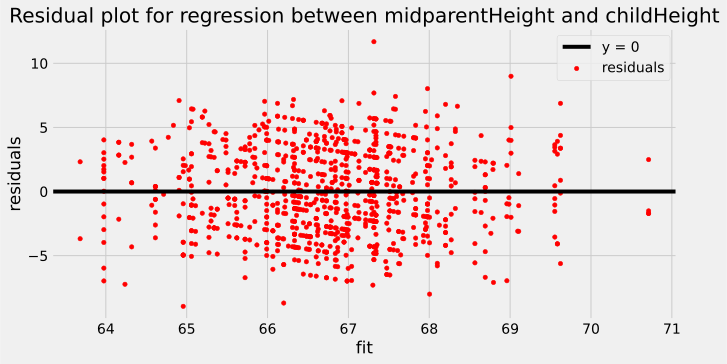

In [6]:
fitted.plot(kind='scatter', x='fit', y='residuals', c='red', figsize=(10, 5), label='residuals')
plt.axhline(0, color='k', label='y = 0')
plt.title('Residual plot for regression between midparentHeight and childHeight')
plt.legend();

### Reading the residual plot

- If a linear fit is good, the residual plot:
    - Should look like a patternless "blob".
    - About half of the data points should be above the horizontal line at 0, and about half should be below.
    - Should have similar vertical spread throughout.
- What happens if these conditions aren't met?

### The residual plot for a non-linear association 🚗
- Consider the hybrid cars dataset from earlier. 
- Let's look at a regression line that uses `'mpg'` to predict `'msrp'`.

In [7]:
hybrid = bpd.read_csv('data/hybrid.csv')
hybrid_fitted = hybrid.assign(
    fit=fit(hybrid, 'mpg', 'msrp'),
    residuals=residual(hybrid, 'mpg', 'msrp')
)
hybrid_fitted

,vehicle,year,msrp,acceleration,mpg,class,fit,residuals
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact,32609.64,-8099.90
1,Tino,2000,35354.97,8.20,54.10,Compact,19278.39,16076.58
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact,28487.75,-1655.50
...,...,...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize,30803.06,2146.94
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize,30803.06,7896.94
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact,37032.62,2112.38


Correlation: -0.5318263633683789


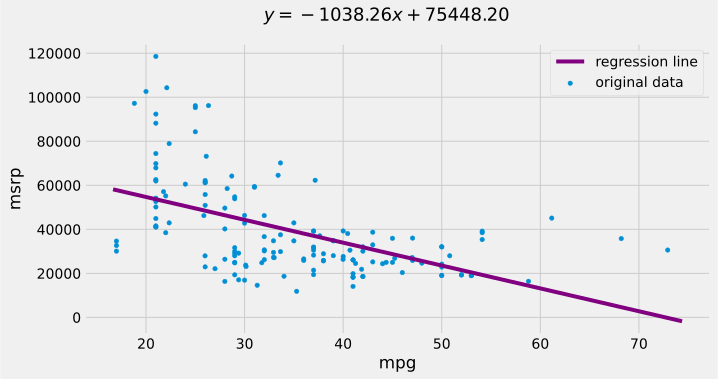

In [8]:
# Plot of the original data and regression line
plot_regression_line(hybrid, 'mpg', 'msrp');
print('Correlation:', correlation(hybrid, 'mpg', 'msrp'))

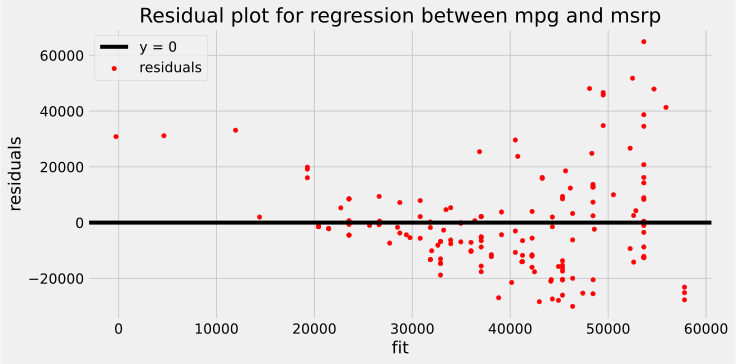

In [9]:
# Residual plot
hybrid_fitted.plot(kind='scatter', x='fit', y='residuals', figsize=(10, 5), color='red', label='residuals')
plt.axhline(0, color='k', label='y = 0')
plt.title('Residual plot for regression between mpg and msrp')
plt.legend();

Note that as `'mpg'` increases, the residuals go from being mostly large, to being mostly small, to being mostly large again. That's a pattern!

### Issue #1: patterns in the residual plot

- Patterns in the residual plot imply that the relationship between $x$ and $y$ may not be linear.
    - While this can be spotted in the original scatter plot, it may be easier to identify in the residual plot.
- In such cases, a curve may be a better choice than a line for prediction.
    - You'll learn more about curve fitting in future courses.

### Another example: `'mpg'` and `'acceleration'` ⛽

- Let's fit a regression line to predict `'acceleration'` given `'mpg'`.
- Let's then look at the resulting residual plot.

In [10]:
accel_mpg = hybrid.assign(
    fit=fit(hybrid, 'acceleration', 'mpg'),
    residuals=residual(hybrid, 'acceleration', 'mpg')
)
accel_mpg

,vehicle,year,msrp,acceleration,mpg,class,fit,residuals
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact,43.29,-2.03
1,Tino,2000,35354.97,8.20,54.10,Compact,41.90,12.20
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact,42.33,2.90
...,...,...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize,35.17,7.83
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize,35.17,7.83
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact,36.40,0.60


Correlation: -0.5060703843771185


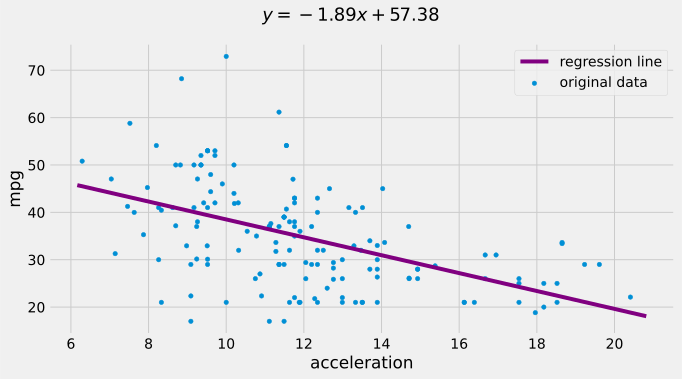

In [11]:
# Plot of the original data and regression line
plot_regression_line(accel_mpg, 'acceleration', 'mpg')
print('Correlation:', correlation(accel_mpg, 'acceleration', 'mpg'))

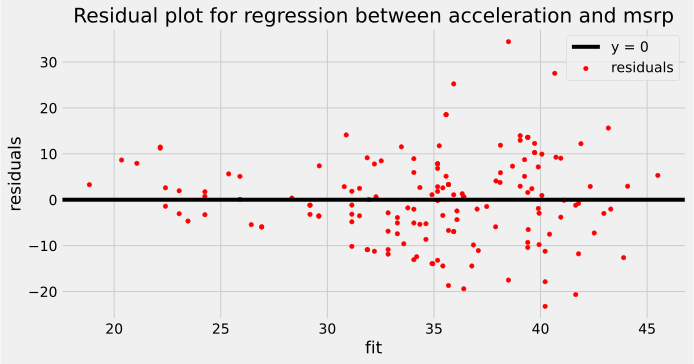

In [12]:
# Residual plot
accel_mpg.plot(kind='scatter', x='fit', y='residuals', figsize=(10, 5), color='red', label='residuals')
plt.axhline(0, color='k', label='y = 0')
plt.title('Residual plot for regression between acceleration and msrp')
plt.legend();

Note that the residuals tend to vary more for smaller accelerations than they do for larger accelerations.

### Issue #2: uneven vertical spread

- If the vertical spread in a residual plot is uneven, it implies that the regression line's predictions aren't equally accurate for all inputs.
    - This doesn't necessarily mean that fitting a nonlinear curve would be better. It just impacts how we interpret the regression line's predictions.
- The formal term for "uneven spread" is **heteroscedasticity**.

### Example: Anscombe's quartet

<center><img src='data/anscombe.png' width=800></center>

- All 4 datasets have the same mean of $x$, mean of $y$, SD of $x$, SD of $y$, and correlation.
    - Therefore, they have the same regression line because the slope and intercept of the regression line are determined by these quantities.
- But they all look very different!
- Not all of them are linearly associated.

### Another Example: The Datasaurus Dozen 🦖

[This dataset](https://www.autodesk.com/research/publications/same-stats-different-graphs) encourages you to "never trust summary statistics alone; always visualize your data"!

<center><img src='data/datasaurus.png' width=800></center>



## Inference for regression

### The regression model

- Recall, a "model" is a set of assumptions about how data were generated.
- The **regression model** states that the data in a scatter plot is generated by
1. taking points on a perfectly straight "true line", and
2. adding vertical "noise" to each point that has a mean of 0.
- If the regression model is satisfied, then a dataset:
    - is shaped like an oval, roughly around an "invisible" true line.
    - has a residual plot with no patterns.

### Another perspective on regression

- What we're really doing:
    - Collecting a sample of data from a population.
    - Fitting a regression line to that sample.
    - Using that regression line to make predictions for inputs that are not in our sample.

- What if we used a different sample? 🤔

### Prediction intervals

Approach:
1. Bootstrap the sample.
2. Compute the slope and intercept of the regression line for that sample.
3. Repeat steps 1 and 2 many times to compute many slopes and many intercepts.
4. Use the bootstrapped slopes and intercepts to create bootstrapped predictions, and take the middle 95% of them.

This will give us a **prediction interval**, i.e. a range of reasonable values for a prediction for a single input.

### Resampling the scatter plot of parent/child heights

Note that each time we run this cell, the resulting line is slighty different!

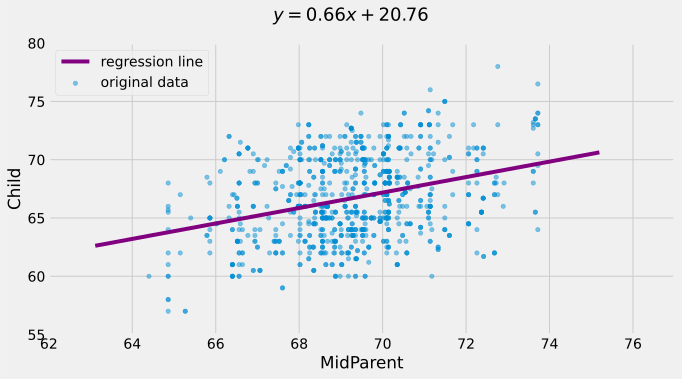

In [13]:
# Resample the dataset
resampled = heights.sample(heights.shape[0], replace=True)

# Plot line of best fit
plot_regression_line(resampled, 'MidParent', 'Child', alpha=0.5)

plt.ylim([55, 80])
plt.xlim([62, 77]);

In [14]:
heights

,MidParent,Child
0,75.43,73.2
1,75.43,69.2
2,75.43,69.0
...,...,...
931,66.64,61.0
932,65.27,66.5
933,65.27,57.0


### You Try: Bootstrapping predictions: parent/child heights

1. Take a bootstrap sample of `heights`. (Take a sample of the same size as `heights` with replacement.)
1. Find the slope and intercept of the best-fit line on the resample. (Hint: Use functions that we've already defined.)
1. Repeat 5,000 times. Keep track of the slopes in `boot_slopes` and the intercepts in `boot_intercepts`.

In [15]:
# The original slope and intercept
m_orig = slope(heights, 'MidParent', 'Child')
b_orig = intercept(heights, 'MidParent', 'Child')

In [16]:
# Bootstrapped slopes and intercepts
boot_slopes = np.array([])
boot_intercepts = np.array([])

for i in np.arange(5000):
    # Step 1: bootstrap the sample
    resample = heights.sample(heights.shape[0], replace=True)
    
    # Step 2: compute the slope and intercept of the regression line for that sample
    m = slope(resample, 'MidParent', 'Child')
    b = intercept(resample, 'MidParent', 'Child')
    boot_slopes = np.append(boot_slopes, m)
    boot_intercepts = np.append(boot_intercepts, b)

### If a midparent height is 74, what is the predicted child's height?

In [17]:
input_value = 74

Using the original dataset, and hence the original slope and intercept, we get a single prediction for the input of 74.

In [18]:
pred_orig = m_orig * input_value + b_orig
pred_orig

69.80094692533117

### You Try: Making a Prediction Interval

1. Use `boot_slopes` and `boot_intercepts` to make bootstrapped predictions for the input of 74. Call this array `boot_preds`.
1. Find a 95% confidence interval for the predictions by taking the 2.5th and 97.5th percentile of the predictions. Store the left endpoint in `l` and the right endpoint in `r`.

In [19]:
boot_preds = boot_slopes * input_value + boot_intercepts
boot_preds

array([69.92, 70.02, 69.41, ..., 70.05, 69.54, 69.5 ])

In [20]:
l = np.percentile(boot_preds, 2.5)
r = np.percentile(boot_preds, 97.5)
[l, r]

[69.18023443716416, 70.4371998563654]

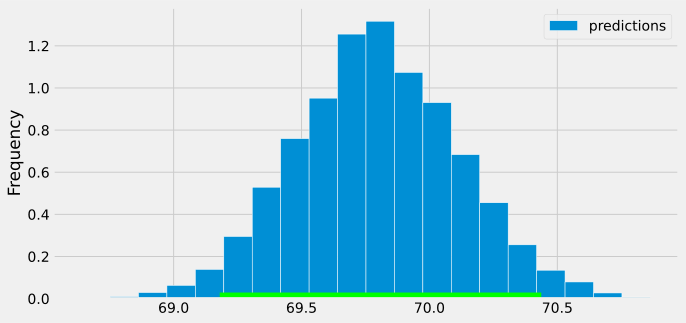

In [21]:
# If all goes well, this cell should run
bpd.DataFrame().assign(
    predictions=boot_preds
).plot(kind='hist', density=True, bins=20, figsize=(10, 5), ec='w')
plt.plot([l,r],[0.01,0.01], c='lime', linewidth=8, zorder=1);

### How different could our prediction have been, for all inputs?

Here, we'll plot 20 of our bootstrapped lines.

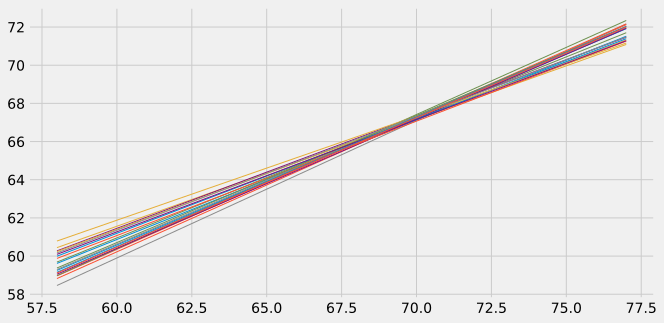

In [22]:
# Don't worry about the code for this.
plt.figure(figsize=(10, 5))
x = np.arange(58, 78)
ys = []
for (m,b) in zip(boot_slopes[:20], boot_intercepts):
    ys.append(m * x + b)
    plt.plot(x, m * x + b, linewidth=1)

### 95% confidence interval for the regression line

This plot shows a 95% confidence interval for where the "true" line lies.

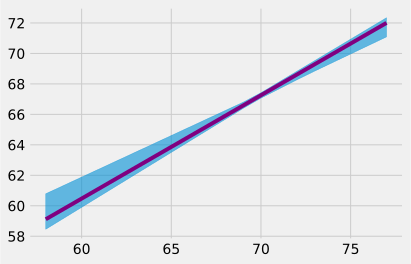

In [23]:
# Don't worry about the code for this.
all_lines = np.vstack(ys)
upper = all_lines.max(axis=0)
lower = all_lines.min(axis=0)

# plot_regression_line(galton, 'midparentHeight', 'childHeight')
plt.fill_between(x, upper, lower, alpha=.6, color='C0')
plt.plot(x, m*x + b, color='purple');

## Why does it matter?

- No use fitting a linear model for nonlinear data!
    - Always need to plot the data before fitting.
- Prediction intervals very useful!
    - Can bootstrap data for almost any model to quantify model's uncertainty.

### Next time

- We'll review in class on Wednesday and Friday.
- No new material after this. 